</br>Рассмотрим структуру архива:
</br>файл data.py - содержит код, использующийся для подгрузки изображений в модель нейронной сети;
</br>файл model.py - содержит исходный код модели U-Net;
</br>папка row - содержит 100 изображений различных отпечатков пальцев, полученных со сканера отпечатков со всеми несовершенствами съема, эти данные будут использоваться как тренировочный набор для второго обучения нейронной сети;
</br>папка processed - содержит 20 вручную обработанных изображений отпечатков пальцев, соответствующих первым 20 изображениям из папки row. Эти данные будут использоваться в качестве меток тренировочного набора для первого и второго обучения нейронной сети;
</br>папка train - содержит первые 20 изображений из папки row, эти данные будут использоваться в качестве тренировочного набора для первого обучения нейронной сети;
</br>папка control - содержит два изображения отпечатка пальца, по которым будет оцениваться эффективность работы нейронной сети по восстановлению поврежденных изображений. Файл 0.png представляет собой одно из исходных изображений, полученных со сканера отпечатков со всеми несовершенствами съема - его мы будем пытаться улучшить с помощью нейронной сети. Файл handmade.png - это вручную обработанный в графическом редакторе файл 0.png - он будет выступать в качестве контрольного и с ним будет сравниваться результат полученный с помощью нейронной сети.


Цель этого кейса на практике рассмотреть подробнее, поднятый в лекциях ТУСУР, вопрос о выделении особых точек отпечатка пальца. Мы напишем код, выполняющий подготовку изображения отпечатка пальца к выделению особых точек, для выполнения необходимых операций будем использовать готовые функции, предоставляемые пакетами <a href="https://opencv.org/">OpenCV</a> (туториалы и дополнительная документация также содержится <a href="https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html">здесь</a>) и <a href="https://scikit-image.org/">SciKit-Image</a>.

In [ ]:
import cv2
from skimage.morphology import skeletonize
import numpy as np

def process_fingerprint(in_image, out_image):
    # считываем изображение из файла in_image
    image=cv2.imread(in_image)

    # сократим количество каналов цветности изображения с трёх (Синий, Зеленый, Красный) до одного - градации серого
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # выполним фильтрацию Гаусса
    # (3, 3) означает, что длина и ширина гауссова фильтра равны 3, а 1,3 означает стандартное отклонение фильтра.
    image=cv2.GaussianBlur(image,(3,3),1.3)

    # выполним бинаризацию, градации серого ярче 127 обратим в белый (255), а остальные - в черный (0)
    ret,image = cv2.threshold(image,127,255,cv2.THRESH_BINARY)

    # выполним скелетирование
    # функция skeletonize ожидает вход в виде булева массива, в котором True соответствует черному цвету, а False - белому
    # приведем массив к такому виду и вызовем функцию skeletonize
    image = image != 255
    image = skeletonize(image)

    # вернем изображение обратно к числовому виду
    image = np.array([np.where(a == False, 255, 0).tolist() for a in image])

    # сохраним результат
    cv2.imwrite(out_image,image)

Далее напишем функцию поиска особых точек в подготовленном изображении

In [ ]:
def find_minutiae(image_file):
    # ветвления, первый массив - координата x, второй - y
    branchings = [[], []]
    # окончания, первый массив - координата x, второй - y
    endings = [[], []]

    # считываем изображение из файла image_file
    image=cv2.imread(image_file)
    
    # сократим количество каналов цветности изображения до одного 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # для упрощения поиска приведем изображение к бинарному виду:
    # 1 - черная точка - идет полоса отпечатка
    # 0 - белая точка - пустое место
    # для этого инвертируем цвета изображения
    image = cv2.bitwise_not(image)
    # и выполним бинаризацию
    ret,image = cv2.threshold(image,128,1,cv2.THRESH_BINARY)

    # теперь пройдемся окном 3х3 по всему изображению
    for y in range(1, len(image) - 1):
        for x in range(1, len(image[y]) - 1):
            # сохраняем данные текущего окна
            window = [[image[y - 1][x - 1], image[y - 1][x], image[y - 1][x + 1]],
                      [image[y][x - 1], image[y][x], image[y][x + 1]],
                      [image[y + 1][x - 1], image[y + 1][x], image[y + 1][x + 1]]]
            window = np.array(window)

            # проверяем содержится ли в центре окна закрашенная точка
            # например:
            # | 0 0 0 |
            # | 0 1 0 |
            # | 0 0 0 |
            if window[1][1] == 1:
                # если в окне всего две закрашенные точки, например:
                # | 0 0 0 |
                # | 1 1 0 |
                # | 0 0 0 |
                # значит центральная точка является окончанием линии
                if np.sum(window) == 2:
                    # сохраняем координаты точки
                    endings[0].append(x)
                    endings[1].append(y)
                # если в окне четыре закрашенные точки, например:
                # | 0 0 1 |
                # | 1 1 0 |
                # | 0 1 0 |
                # значит центральная точка является ветвлением линии
                if np.sum(window) == 4:
                    # сохраняем координаты точки
                    branchings[0].append(x)
                    branchings[1].append(y)

    return branchings, endings

Опустим необходимость удаления особых точек по краю отпечатка пальца и дублирующухся точек ветвления, в рамках данной работы для нас это не существенно.

Теперь мы можем отрисовать особые точки. Для начала, чтобы проблема стала очевидна, представим, что сканеры отпечатков пальцев работают идеально и выдают результат без непрожатых участков и с высочайшей контрастностью как, например, изображение handmade.png в папке control. Обработаем данное изображение

In [ ]:
%pwd

'/kaggle/working'

Ветвления: 28 точек
Окончания: 83 точек


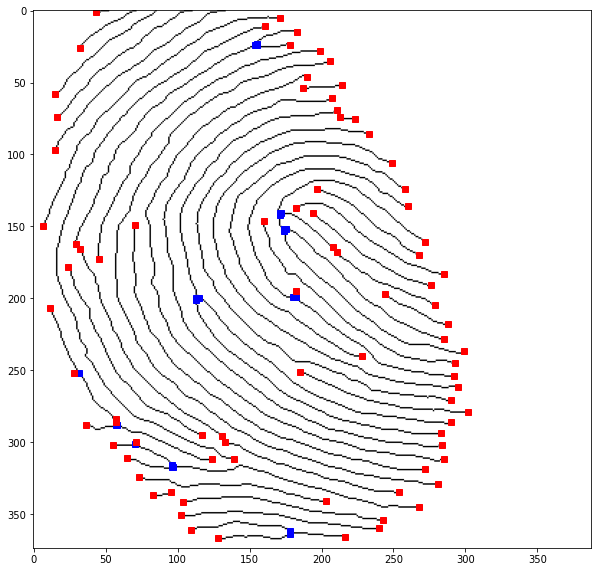

In [ ]:
import matplotlib.pyplot as plt

# подготовим изображение, результат сохраним в формате bmp, чтобы не было никаких потерь при сжатии
# Скорректируйте путь с учетом Вашего названия датасета, в примере он был назван fingerprints
process_fingerprint('../input/materials7/model/control/handmade.png', 'skelet_handmade.bmp')

test_file = 'skelet_handmade.bmp'
# найдем минуции
bran, ends = find_minutiae(test_file)
print('Ветвления:', len(bran[0]), 'точек')
print('Окончания:', len(ends[0]), 'точек')

# отрисуем минуции на изображении
image=cv2.imread(test_file)
plt.rcParams["figure.figsize"] = (10,10)
imgplot = plt.imshow(image)
plt.plot(bran[0], bran[1], marker='s', color="blue", linestyle = 'None')
plt.plot(ends[0], ends[1], marker='s', color="red", linestyle = 'None')
plt.show()

Сохраним полученные значения количества ветвлений и окончаний. С этими значениями мы будем проводить сравнение в дальнейшем

К сожалению, в реальности такие отпечатки - редкость и чаще мы имеем дело с изображениями вроде 0.png в папке control (файл control/0.png). Выполним для него тот же код

Ветвления: 0 точек
Окончания: 146 точек


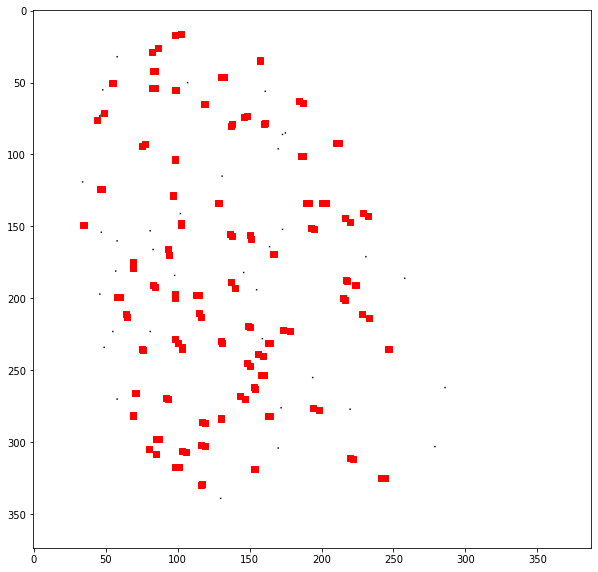

In [ ]:
# подготовим изображение, результат сохраним в формате bmp, чтобы не было никаких потерь при сжатии
process_fingerprint('../input/materials7/model/control/0.png', 'skelet_row.bmp')

test_file = 'skelet_row.bmp'
# найдем минуции
bran, ends = find_minutiae(test_file)
print('Ветвления:', len(bran[0]), 'точек')
print('Окончания:', len(ends[0]), 'точек')

# отрисуем минуции на изображении
image=cv2.imread(test_file)
plt.rcParams["figure.figsize"] = (10,10)
imgplot = plt.imshow(image)
plt.plot(bran[0], bran[1], marker='s', color="blue", linestyle = 'None')
plt.plot(ends[0], ends[1], marker='s', color="red", linestyle = 'None')
plt.show()

Как мы видим, часть особых точек ветвления была потеряна и при этом появилось множество ложных точек окончаний. Использование таких изображений в системах аутентификации ведет к их крайне низкой надежности. Для исправления этой проблемы и используется рекурсивное восстановление с помощью нейронной сети.

Для обучения нейронной сети все еще необходимы данные, поэтому для начала все-таки приходится обработать часть датасета отпечатков пальцев вручную. К счастью, нет необходимости обрабатывать весь датасет (в полной версии датасета несколько тысяч отпечатков пальцев), двух десятков изображений будет вполне достаточно. В папке processed как раз и содержатся такие изображения, обучим на них нейронную сеть U-Net.

2022-11-01 08:00:40.915825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 08:00:40.916865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 08:00:41.331333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 08:00:41.332261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 08:00:41.333156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


2022-11-01 08:00:47.576241: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3000
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


2022-11-01 08:00:51.212245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1/1 [==============================] - 23s 23s/step - loss: 0.7208 - accuracy: 0.7050 - f1_m: 0.8270 - precision_m: 0.7050 - recall_m: 1.0000

Epoch 00001: loss improved from inf to 0.72082, saving model to unet_fingerprint.hdf5
Epoch 2/3000
1/1 [==============================] - 0s 301ms/step - loss: 0.5576 - accuracy: 0.7664 - f1_m: 0.8672 - precision_m: 0.7697 - recall_m: 0.9930

Epoch 00002: loss improved from 0.72082 to 0.55757, saving model to unet_fingerprint.hdf5
Epoch 3/3000
1/1 [==============================] - 0s 297ms/step - loss: 0.4071 - accuracy: 0.8535 - f1_m: 0.9210 - precision_m: 0.8541 - recall_m: 0.9992

Epoch 00003: loss improved from 0.55757 to 0.40714, saving model to unet_fingerprint.hdf5
Epoch 4/3000
1/1 [==============================] - 0s 297ms/step - loss: 0.4196 - accuracy: 0.8095 - f1_m: 0.8946 - precision_m: 0.8093 - recall_m: 0.9999

Epoch 00004: loss did not improve from 0.40714
Epoch 5/3000
1/1 [==============================] - 0s 297ms/step - loss:

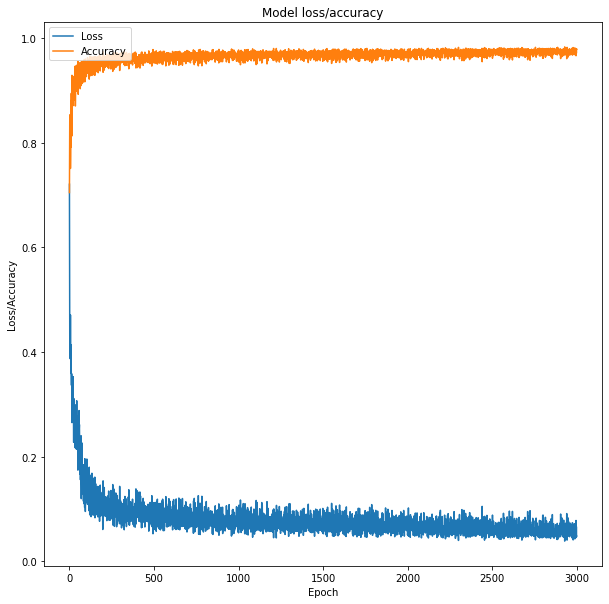

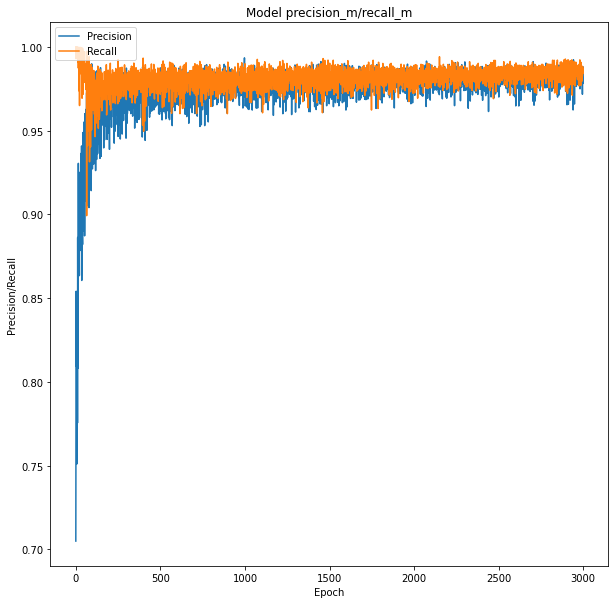

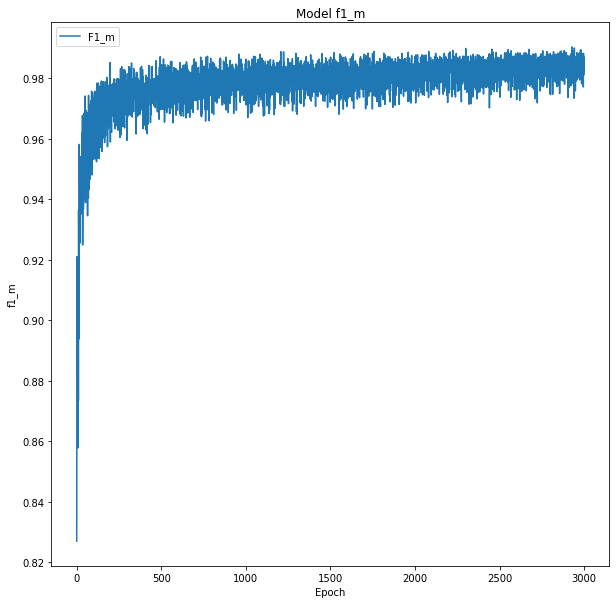

In [ ]:
# подключим к среде папку с исполняемыми модулями сети U-Net
import sys
sys.path.insert(1, '../input/materials7/model/')
# если операция выполняется не в первый раз удалим предыдущий снимок модели
# обучение будем проводить "с нуля"
import os
if os.path.exists('unet_fingerprint.hdf5'):
    os.remove('unet_fingerprint.hdf5')

import tensorflow as tf
import numpy as np
seed_value=29328248
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# подключаем модули U-Net
from model import *
from data import *
# подключим модуль отрисовки графиков
import matplotlib.pyplot as plt

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

# инициализируем подгрузчик данных, укажем папку с датасетов - ../input/model-data/
# папку с тренировочными примерами - train и их улучшенными копиями - processed
myGene = trainGenerator(2,'../input/materials7/model/','train','processed',data_gen_args,save_to_dir = None)

# обучаем модель и отрисовываем динамику ее обучения
model = unet()
model_checkpoint = ModelCheckpoint('unet_fingerprint.hdf5', 
                                   monitor='loss',verbose=1, save_best_only=True)
result = model.fit(myGene,steps_per_epoch=1,epochs=3000,callbacks=[model_checkpoint])

plt.plot(result.history['loss'])
plt.plot(result.history['accuracy'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')
plt.show()

plt.plot(result.history['precision_m'])
plt.plot(result.history['recall_m'])
plt.title('Model precision_m/recall_m')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['Precision', 'Recall'], loc='upper left')
plt.show()

plt.plot(result.history['f1_m'])
plt.title('Model f1_m')
plt.ylabel('f1_m')
plt.xlabel('Epoch')
plt.legend(['F1_m'], loc='upper left')
plt.show()


Создадим папку, в которую будем сохранять предсказания нейронной сети на контрольном примере

In [ ]:
!mkdir out_test

Автоматизировано улучшим контрольное изображение с помощью обученной нейронной сети, результат будет расположен в папке out_test в файле 0_predict.png

In [ ]:
from model import *
from data import *

model = unet()
model.load_weights('unet_fingerprint.hdf5')
testGene = testGenerator("../input/materials7/model/control/", num_image=1)
results = model.predict(testGene,1,verbose=1)
saveResult("out_test/",results)

1/1 [==============================] - 4s 4s/step


Для полученного обработанного отпечатка также выполним обработку и попробуем выделить особые точки

Ветвления: 7 точек
Окончания: 142 точек


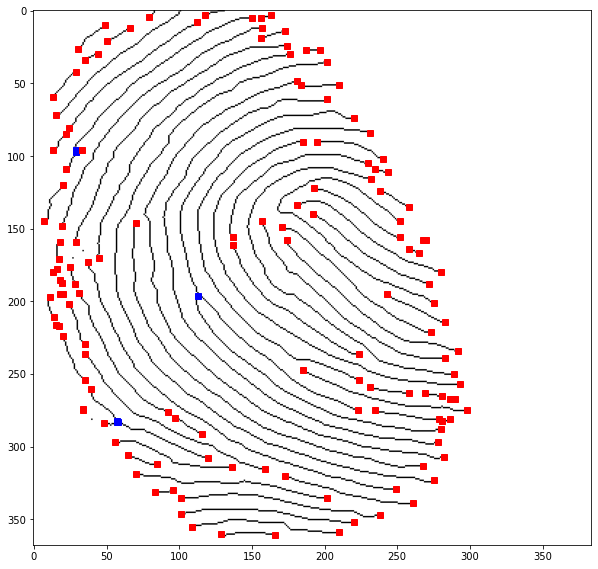

In [ ]:
process_fingerprint('./out_test/0_predict.png', 'skelet_predict.bmp')

test_file = 'skelet_predict.bmp'
# найдем минуции
bran, ends = find_minutiae(test_file)
print('Ветвления:', len(bran[0]), 'точек')
print('Окончания:', len(ends[0]), 'точек')

# отрисуем минуции на изображении
image=cv2.imread(test_file)
plt.rcParams["figure.figsize"] = (10,10)
imgplot = plt.imshow(image)
plt.plot(bran[0], bran[1], marker='s', color="blue", linestyle = 'None')
plt.plot(ends[0], ends[1], marker='s', color="red", linestyle = 'None')
plt.show()

Результат теперь уже значительно лучше. Но можно его улучшить еще больше - мы ведь обучили модель всего на 20 примерах. Теперь у нас уже имеется иструмент для улучшения отпечатков, пусть и не идеально работающий, и нам больше не нужно вручную отрисовывать улучшенные версии отпечатков. За нас это будет делать нейронная сеть. Мы выберем лучшие результаты и дообучим эту же нейронную сеть на сгенерированных ею же данных - это и есть подход **рекурсивного (или рекуррентного) обучения**. Мы имеем 100 изображений, сгенерируем их улучшенные версии с помощью нашей сети.

In [ ]:
# создадим папку для сохранения сгенерированного результата
!mkdir generated

from model import *
from data import *

model = unet()
model.load_weights('unet_fingerprint.hdf5')
testGene = testGenerator("../input/materials7/model/row/", num_image=100)
results = model.predict(testGene,100,verbose=1)
saveResult("generated/",results)

100/100 [==============================] - 6s 53ms/step


Предположим, что все 100 полученных изображений нас устраивают и мы решили обучить на них нейронную сеть. Соберем новый набор меток для тренировочных данных: первые 20 изображений возьмем из числа отрисованных вручную (из папки ../input/model-data/processed/), а оставшиеся 80 изображений, для которых у нас нет ручных версий, возьмем из тех, что сгенерировала нейронная сеть (из папки generated).
Создадим для этого новую папку

In [ ]:
!mkdir lables

И скопируем туда изображения

In [ ]:
import shutil

for i in range(0, 20):
    src = '../input/materials7/model/processed/' + str(i) + '.png'
    dst = 'lables/' + str(i) + '.png'
    shutil.copy(src, dst)
    
for i in range(20, 100):
    src = 'generated/' + str(i) + '_predict.png'
    dst = 'lables/' + str(i) + '.png'
    shutil.copy(src, dst)

Также скопируем в рабочую область Kaggle из датасета папку с исходными 100 изображениями (row). Это делается для того, чтобы тренировочные данные и метки к ним находились в одной и той же папке, чтобы подгрузчик датасета их без проблем нашел.

In [ ]:
!cp -r ../input/materials7/model/row /kaggle/working/

Дообучим модель на 100 примерах

In [ ]:
import tensorflow as tf
import numpy as np

seed_value=29328248
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

from model import *
from data import *
import matplotlib.pyplot as plt

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(2,'.','row','lables',data_gen_args,save_to_dir = None)

model = unet()
model.load_weights('unet_fingerprint.hdf5')
model_checkpoint = ModelCheckpoint('unet_fingerprint.hdf5', 
                                   monitor='loss',verbose=1, save_best_only=True)
result = model.fit(myGene,steps_per_epoch=1,epochs=3000,callbacks=[model_checkpoint])

plt.plot(result.history['loss'])
plt.plot(result.history['accuracy'])
plt.title('Model loss/accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')
plt.show()

plt.plot(result.history['precision_m'])
plt.plot(result.history['recall_m'])
plt.title('Model precision_m/recall_m')
plt.ylabel('Precision/Recall')
plt.xlabel('Epoch')
plt.legend(['Precision', 'Recall'], loc='upper left')
plt.show()

plt.plot(result.history['f1_m'])
plt.title('Model f1_m')
plt.ylabel('f1_m')
plt.xlabel('Epoch')
plt.legend(['F1_m'], loc='upper left')
plt.show()

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Epoch 1/3000
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
1/1 [==============================] - 2s 2s/step - loss: 0.0758 - accuracy: 0.9670 - f1_m: 0.9795 - precision_m: 0.9797 - recall_m: 0.9792

Epoch 00001: loss improved from inf to 0.07575, saving model to unet_fingerprint.hdf5
Epoch 2/3000
1/1 [==============================] - 0s 319ms/step - loss: 0.1050 - accuracy: 0.9561 - f1_m: 0.9730 - precision_m: 0.9568 - recall_m: 0.9897

Epoch 00002: loss did not improve from 0.07575
Epoch 3/3000
1/1 [==============================] - 0s 322ms/step - loss: 0.0925 - accuracy: 0.9596 - f1_m: 0.9738 - precision_m: 0.9759 - recall_m: 0.9718

Epoch 00003: loss did not improve from 0.07575
Epoch 4/3000
1/1 [==============================] - 0s 329ms/step - loss: 

Автоматизировано улучшим контрольное изображение с помощью обученной нейронной сети, результат будет расположен в папке out_test в файле 0_predict.png

In [ ]:
from model import *
from data import *

model = unet()
model.load_weights('unet_fingerprint.hdf5')
testGene = testGenerator("../input/materials7/model/control/", num_image=1)
results = model.predict(testGene,1,verbose=1)
saveResult("out_test/",results)

1/1 [==============================] - 0s 279ms/step


Для полученного обработанного отпечатка также выполним обработку и попробуем выделить особые точки

Ветвления: 12 точек
Окончания: 153 точек


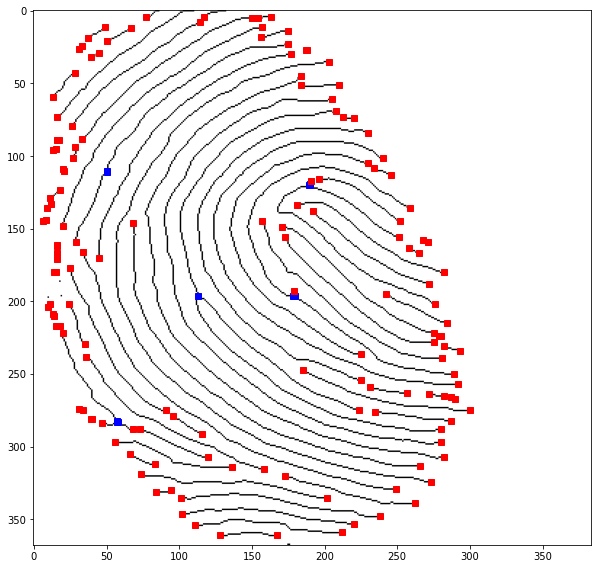

In [ ]:
process_fingerprint('out_test/0_predict.png', 'skelet_last.bmp')

test_file = 'skelet_last.bmp'
# найдем минуции
bran, ends = find_minutiae(test_file)
print('Ветвления:', len(bran[0]), 'точек')
print('Окончания:', len(ends[0]), 'точек')

# отрисуем минуции на изображении
image=cv2.imread(test_file)
plt.rcParams["figure.figsize"] = (10,10)
imgplot = plt.imshow(image)
plt.plot(bran[0], bran[1], marker='s', color="blue", linestyle = 'None')
plt.plot(ends[0], ends[1], marker='s', color="red", linestyle = 'None')
plt.show()

Как мы видим результат незначительно улучшился относительно того, что выдавала нейронная сеть на прошлой итерации обучения, но все еще не совпадающий с ручной обработкой. 
Для получения идеального результата необходимо:
</br>1 Вручную отбирать качественные результаты предсказаний нейронной сети;
</br>2 Постепенно увеличивая количество изображений на каждой итерации, провести около полутора десятков обучений сети до получения желаемого результата.